# Introduction
This notebook presents an exploratory analysis of a chat history. It demonstrates how to load and clean the data, extract useful information, and visualize the results in a fun and aesthetic manner. The analysis includes the frequency of messages over time, the most active users, and a sentiment analysis of the messages. The methods used here can be applied to any chat history.

In [ ]:
!pip install emoji
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install textblob
!pip install wordcloud
!pip install palettable
!pip install stop-words
!pip install nltk
!pip install spacy
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/noteable/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading & Cleaning
We start by loading the chat data from the `_chat.txt` file and then split to columns using re. 

Empty or N/A columns and rows are then dropped, datetime is processed, and system messages are removed.

In [ ]:
import pandas as pd
import re

# Import the data as if it were a csv
chat_data = pd.read_csv('_chat.txt', sep='	', header=None)
chat_data.head()

# Define a function to process the text file to a datafram
def split_chat_line(line):
    match = re.match(r'\[(.*?)\] (.*?): (.*)', line)
    if match:
        return match.groups()
    else:
        return None, None, line

chat_data[['datetime', 'user', 'message']] = chat_data[0].apply(split_chat_line).apply(pd.Series)
chat_data['datetime'] = pd.to_datetime(chat_data['datetime'], format='%d/%m/%Y, %I:%M:%S %p')
chat_data = chat_data.drop(columns=[0])

# Drop any rows with missing values
chat_data.dropna(inplace=True)

# Remove group name from user names
first_user = chat_data['user'].iloc[0]
chat_data = chat_data[chat_data['user'] != first_user]



# Exploratory Analysis
The exploratory analysis includes several visualizations. The number of messages over time is plotted as a line graph, showing how the activity in the chat has changed. 

The number of messages by each user is plotted as a bar graph, showing who the most active users are. Message length by user and time of day are also analysed.

Emoji frequencies are plotted using the emoji library.


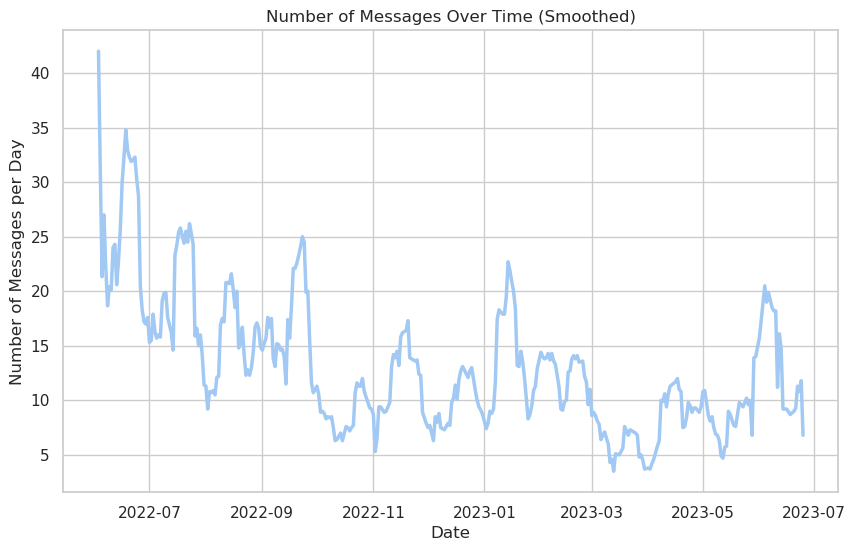

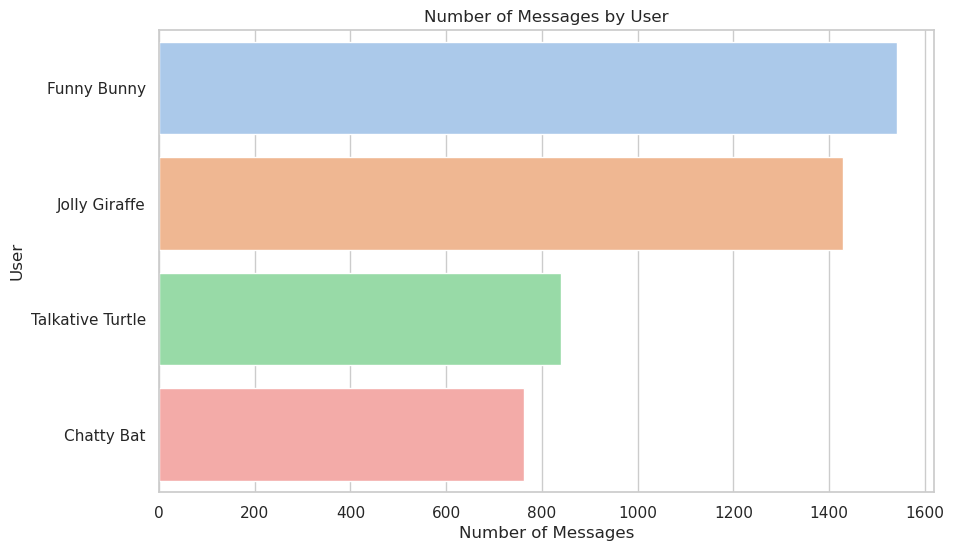

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

chat_data['date'] = chat_data['datetime'].dt.date
message_counts = chat_data['date'].value_counts().sort_index()
user_message_counts = chat_data['user'].value_counts()

###### Optional - alias the users and scrub phone numbers ######
# Define a list of aliases
aliases = ['Funny Bunny', 'Chatty Bat', 'Talkative Turtle', 'Jolly Giraffe', 'Big Brown', 'The Crab Guy']

# Get the unique user names
users = chat_data['user'].unique()

# Create a dictionary that maps each user name to an alias
user_aliases = dict(zip(users, aliases))

# Replace the user names with their aliases
chat_data['user'] = chat_data['user'].replace(user_aliases)

# Check if there are more users than aliases
if len(users) > len(aliases):
    raise ValueError('There are more users than aliases. Please add more aliases.')
    
# Define a regular expression for phone numbers
phone_number_regex = r'614\d{8}'

# Replace phone numbers with 'xxxxxxxxx'
chat_data['message'] = chat_data['message'].str.replace(phone_number_regex, 'xxxxxxxxx', regex=True)

###### End optional ######

# Create a dictionary that maps each user name to an alias
user_aliases = dict(zip(users, aliases))

# Replace the user names with their aliases
chat_data['user'] = chat_data['user'].replace(user_aliases)


sns.set(style='whitegrid', palette='pastel')

# Apply a simple moving average (rolling mean) to the message_counts data
window_size = 10  # Adjust the window size as per your preference
smoothed_message_counts = message_counts.rolling(window=window_size, min_periods=1).mean()

# Draw number of messages over time with a slightly smoothed line
plt.figure(figsize=(10, 6))
sns.lineplot(x=smoothed_message_counts.index, y=smoothed_message_counts.values, linewidth=2.5)
plt.title('Number of Messages Over Time (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Number of Messages per Day')
plt.show()

# Draw the number of messages by user
plt.figure(figsize=(10, 6))
sns.barplot(x=user_message_counts.values, y=user_message_counts.index)
plt.title('Number of Messages by User')
plt.xlabel('Number of Messages')
plt.ylabel('User')
plt.show()


In [ ]:
# Add a new column for the length of each message
chat_data['message_length'] = chat_data['message'].str.len()

# Get the index of the shortest message
shortest_message_index = chat_data['message_length'].min()

# Get the index of the longest message
longest_message_index = chat_data['message_length'].max()

print(longest_message_index)
print(shortest_message_index)

####### Optional: Print the shortest and longest messages
# print('Shortest message:', chat_data.loc[shortest_message_index, 'message'])
# print('Longest message:', chat_data.loc[longest_message_index, 'message'])


460
1


In [ ]:
### Optional - this section changes the index and may not play well with other code
# Set the timestamp column as the index
# chat_data.set_index('datetime', inplace=True)

# Resample the data to a weekly frequency and count the number of messages in each week
# message_counts_by_week = chat_data.resample('W').size()

# Get the starting dates of the busiest and least busy weeks
# busiest_week_start = message_counts_by_week.idxmax()
# least_busy_week_start = message_counts_by_week.idxmin()

# Print the starting dates of the busiest and least busy weeks and the number of messages in these weeks
# print('Busiest week starting:', busiest_week_start, 'Number of messages:', message_counts_by_week[busiest_week_start])
# print('Least busy week starting:', least_busy_week_start, 'Number of messages:', message_counts_by_week[least_busy_week_start])


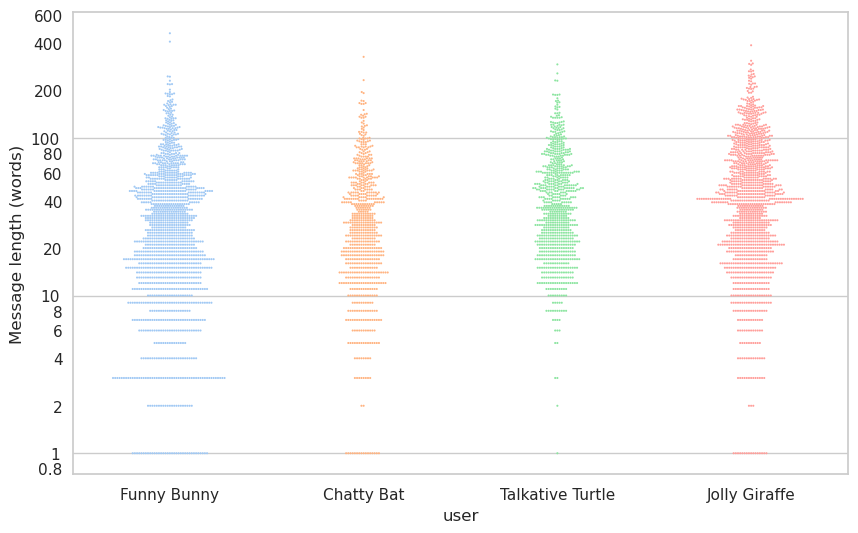

In [ ]:
import matplotlib.ticker as ticker

# Create a new column for the length of each message
chat_data['Message length (words)'] = chat_data['message'].apply(len)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Add a swarmplot of message length
sns.swarmplot(x='user', y='Message length (words)', data=chat_data, hue='user', size=1.5, ax=ax, palette='pastel')

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Change the y-axis tick labels to display as integer values
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# Set the major and minor tick locations
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks = 10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8)))

# Remove the legend
ax.get_legend().remove()

# Save the figure to a variable
swarm_plot_fig = fig


In [ ]:
import emoji

# Extract all emojis from the messages
def extract_emojis(s):
    emojis = emoji.distinct_emoji_list(s)
    return ''.join(emojis)

chat_data['emojis'] = chat_data['message'].apply(extract_emojis)

# Count the frequency of each emoji
emoji_counts = chat_data['emojis'].value_counts().head(11)

# Remove blank from emoji counts
emoji_counts = emoji_counts[emoji_counts.index != '']

emoji_counts


In [ ]:
import plotly.graph_objects as go

# Create a DataFrame for the top 10 emojis
emoji_df = emoji_counts.reset_index()
emoji_df.columns = ['emoji', 'count']

# Create a bar plot with pastel-colored bars
fig = go.Figure()

# Add the visible bars with pastel color
fig.add_trace(go.Bar(x=emoji_df['emoji'], y=emoji_df['count'], marker_color='#87CEEB'))

# Add the text annotations with emojis
for i, row in emoji_df.iterrows():
    fig.add_annotation(x=row['emoji'], y=row['count'], text=row['emoji'], font={'size': 40},
                       showarrow=False, align='center', yshift=10)

# Set the title and layout
fig.update_layout(title='Frequency of Top 10 Emojis', plot_bgcolor='white')

# Update x-axis and hide labels
fig.update_xaxes(showticklabels=False)

# Show the plot
fig.show()


In [ ]:
# Print a table of emoji usage
emoji_df['Alias'] = emoji_df['emoji'].apply(lambda x: emoji.EMOJI_DATA[x]['alias'][0] if 'alias' in emoji.EMOJI_DATA[x] else '')

print(emoji_df)



  emoji  count                             Alias
0     🤣    117                            :rofl:
1     🥹     95                                  
2     🥰     83  :smiling_face_with_three_hearts:
3     😂     77                             :joy:
4     😜     63    :stuck_out_tongue_winking_eye:
5     😍     57                      :heart_eyes:
6    ♥️     56                          :hearts:
7    ❤️     50                           :heart:
8     😭     46                             :sob:
9     😬     12                       :grimacing:


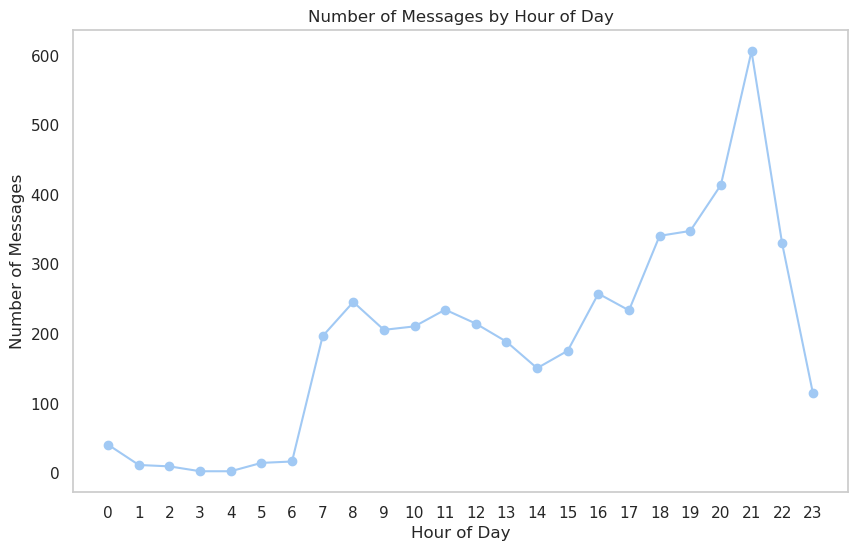

In [ ]:
# Time of day analysis
chat_data['hour'] = chat_data['datetime'].dt.hour

# Group by hour and count the number of messages
hourly_counts = chat_data.groupby('hour')['message'].count()

# Plot the hourly message counts
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.xticks(range(24), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])
plt.title('Number of Messages by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.grid()
plt.show()

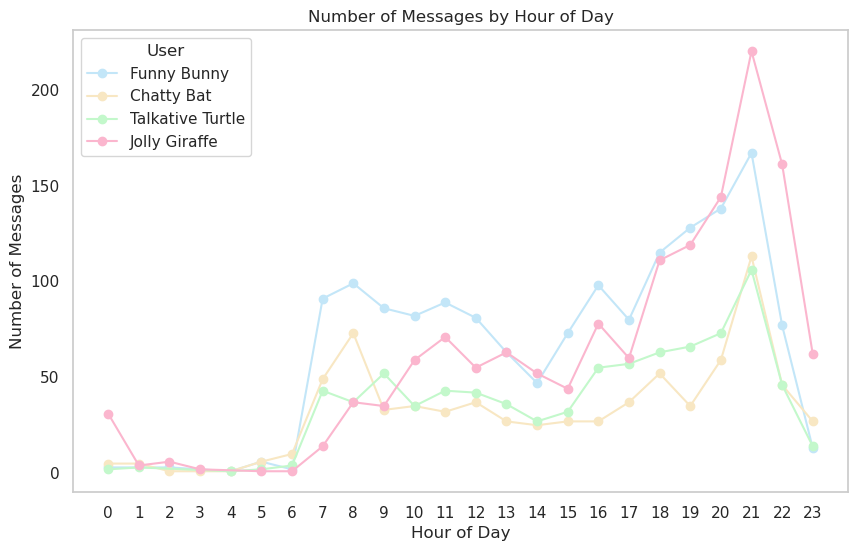

In [ ]:
import matplotlib.pyplot as plt

# Get the unique users
users = chat_data['user'].unique()

# Define a pastel color palette
pastel_colors = ['#C3E6F8', '#F8E7C3', '#C3F8CB', '#FBB6CE']

plt.figure(figsize=(10, 6))

# Iterate over each user
for i, user in enumerate(users):
    # Filter the data for the current user
    user_data = chat_data[chat_data['user'] == user]
    
    # Group by hour and count the number of messages
    hourly_counts = user_data.groupby('hour')['message'].count()
    
    # Plot the hourly message counts by user
    plt.plot(hourly_counts.index, hourly_counts.values, marker='o', color=pastel_colors[i % len(pastel_colors)], label=user)

plt.xticks(range(24), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])
plt.title('Number of Messages by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='User')
plt.grid()
plt.show()


In [ ]:
import plotly.graph_objects as go

# Time of day analysis
chat_data['hour'] = chat_data['datetime'].dt.hour

# Group by hour and count the number of messages
hourly_counts = chat_data.groupby('hour')['message'].count()

# Define the emoji labels for each hour
emoji_labels = ['🌙', '1', '2', '3', '4', '5', '🌅', '7', '8', '9', '10', '11', '🌞', '13', '14', '15', '16', '17', '🌆', '19', '20', '21', '22', '23']

# Create a circular plot with emojis
fig = go.Figure(go.Scatterpolar(
    r=hourly_counts.values,
    theta=[f'hour {hour}' for hour in hourly_counts.index],
    mode='lines+markers',
    fill='toself',
    line_color='#87CEEB',
    marker=dict(
        color='#87CEEB',
        size=5,
        symbol='circle',
        opacity=0.8
    ),
    hovertemplate='%{theta}: %{r} messages<br>%{text}',
    text=emoji_labels
))

# Set the layout and theme
fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=False),
        angularaxis=dict(
            direction='clockwise',
            showticklabels=True,
            tickvals=[f'hour {hour}' for hour in hourly_counts.index],
            ticktext=emoji_labels,
            tickfont=dict(size=14),
            tickangle=90,
            ticks=''
        )
    ),
    showlegend=False,
    plot_bgcolor='white'
)

# Show the plot
fig.show()


## Text analysis
A sentiment analysis is performed on the messages, using the TextBlob library to calculate the polarity (positive or negative sentiment) of each message. 

NLTK is then used to clean text and calculate word frequencies for a wordcloud plot using the WordCloud library.

In [ ]:
# Perform sentiment analysis per user
from textblob import TextBlob
import plotly.express as px

# Function to get the polarity of a text
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the 'message' column
chat_data['polarity'] =chat_data['message'].apply(get_polarity)

# Group by user and calculate the mean polarity
user_sentiment = chat_data.groupby('user')['polarity']
user_sentiment

import plotly.graph_objects as go

# Define a pastel color palette
pastel_colors = ['#C3E6F8', '#F8E7C3', '#C3F8CB', '#FBB6CE']

fig = go.Figure()

# Iterate over each user and create a box plot
for i, user in enumerate(chat_data['user'].unique()):
    user_data = chat_data[chat_data['user'] == user]
    fig.add_trace(go.Box(y=user_data['polarity'], name=user, marker_color=pastel_colors[i % len(pastel_colors)]))

# Add a dotted zero line
fig.add_shape(type='line', x0=-0.5, y0=0, x1=len(chat_data['user'].unique()) - 0.5, y1=0, line=dict(color='black', dash='dot'))

# Update the layout
fig.update_layout(
    title='Sentiment Analysis by User',
    yaxis_title='Polarity',
    xaxis_title='User',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show the plot
fig.show()

In [ ]:
# Add a new column for the day of each message
chat_data['day'] = chat_data['datetime'].dt.date

# Group the messages by day and calculate the mean polarity for each day
mean_polarity_by_day = chat_data.groupby('day')['polarity'].mean()

# Get the most and least positive days
most_positive_day = mean_polarity_by_day.idxmax()
least_positive_day = mean_polarity_by_day.idxmin()

# Print the most and least positive days and the mean polarity on these days
print('Most positive day:', most_positive_day, 'Mean polarity:', mean_polarity_by_day[most_positive_day])
print('Least positive day:', least_positive_day, 'Mean polarity:', mean_polarity_by_day[least_positive_day])

# Select the messages from the most positive/negative day
most_positive_day_messages = chat_data[chat_data['day'] == most_positive_day]['message']
least_positive_day_messages = chat_data[chat_data['day'] == least_positive_day]['message']

print(least_positive_day_messages)
print(most_positive_day_messages)


Most positive day: 2023-02-25 Mean polarity: 0.78125
Least positive day: 2022-10-29 Mean polarity: -0.41666666666666663
3337    Reception gonna be funnnn!
3339           That is impossible!
Name: message, dtype: object
5113    This is adorable!! And relatable.
Name: message, dtype: object


In [ ]:
# Get the overall user sentiment mean
print(user_sentiment.mean())

user
Chatty Bat          0.113957
Funny Bunny         0.148352
Jolly Giraffe       0.107861
Talkative Turtle    0.233808
Name: polarity, dtype: float64


In [ ]:
# Add a new column for the day of the week
chat_data['day_of_week'] = chat_data['datetime'].dt.dayofweek

# Create a pivot table for sentiment analysis
pivot_table = chat_data.pivot_table(values='polarity', index='hour', columns='day_of_week', aggfunc=np.mean)

# Replace the integers with the names of the days
pivot_table.columns = pivot_table.columns.to_series().replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=pivot_table.values,
    x=pivot_table.columns,
    y=pivot_table.index,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
))

# Update the layout
fig.update_layout(
    title='Sentiment Analysis by Day of Week and Hour of Day',
    xaxis_title='Day of Week',
    yaxis_title='Hour of Day',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show the plot
fig.show()


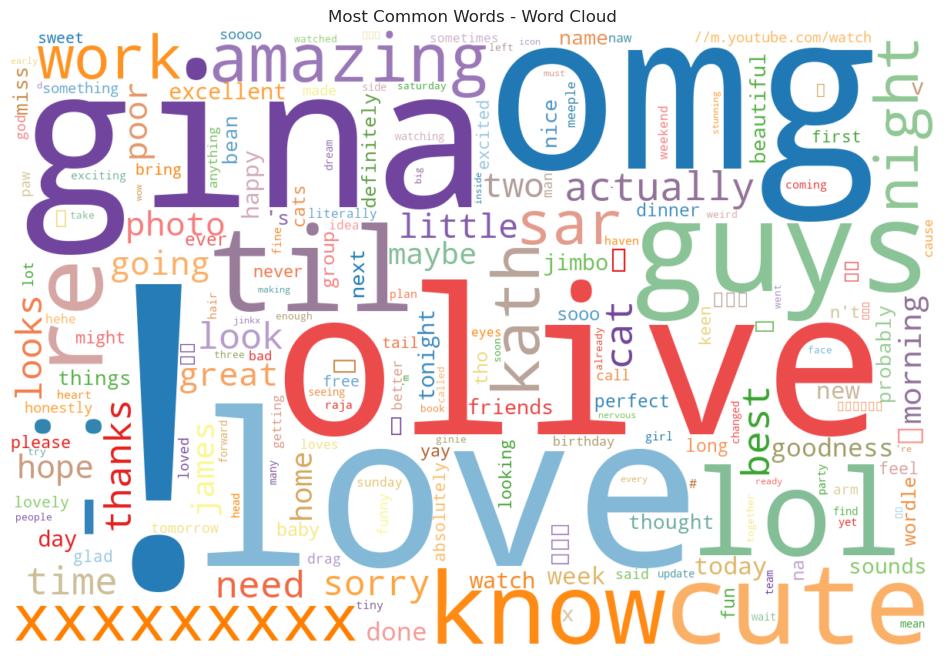

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
from palettable.colorbrewer.qualitative import Paired_12
from stop_words import get_stop_words
import nltk
from nltk.tokenize import word_tokenize

# Function to get the most common words in a text
def get_common_words(text, n=10):
    words = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    word_counts = Counter(words)
    return dict(word_counts.most_common(n))

# Apply the function to the 'message' column
chat_data['common_words'] = chat_data['message'].apply(get_common_words)

# Combine the common words from all users
all_common_words = Counter()
for words in chat_data['common_words']:
    all_common_words += Counter(words)

# Remove common stop words
stopwords = set(get_stop_words('en'))  # Set of stopwords from stop-words library
stopwords.update([word.lower() for word in ["I'm", "just", "Oh", "didn't", "u", "This", "I", "We", "also", "can't", "I've", "That's", "way", "gonna", "Can", "I'll", "see", "When", "got", "The", "us", "Is", "Also", "get", "really", "come", "can't", "didn't", "can", "What", "Not", "now", "very", "back", "so", "Just", "That", "the", "to", "and", "in", "it", "is", "of"]])  # Add your custom stopwords here

# Add more stopwords
stopwords.update(["its", "it s", "youre", "thats", "im", "think", "dont", "were", "put", "make", "good", "always", "yeah", "ok", "okay", "well", "hmm", "umm", "like", "youre", "theyre", "were", "its", "hes", "shes", "thats", "theres", "id", "youd", "hed", "shed", "wed", "theyd", "ill", "youll", "hell", "shell", "well", "theyll", "isnt", "arent", "wasnt", "werent", "hasnt", "havent", "hadnt", "doesnt", "dont", "didnt", "wont", "wouldnt", "shant", "shouldnt", "cant", "cannot", "couldnt", "mustnt", "lets", "thats", "whos", "whats", "heres", "theres", "whens", "wheres", "whys", "hows"])

# Add even more stopwords specific to messenger chats
stopwords.update(["ill", "ive", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "im", "m", "ve", "" "were", "its", "im" "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "myself", "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other", "ought",  "ourselves", "out", "over", "own", "same", "shan't", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "s", "don", "https", "..", ".", "go", "last", """""", '"', "though", "want", "last", "%", "/", "&", "seen", "'", " '", "' ", "w", "ll", "tell", "n't" ':', ": ", ' ', "|", "I", "''" """'""", """' '""", "“", "ʺ", ",", "ˊ", "′", "ʼ", '’', "‛", "‘" '“', '”'])


# Add even more stopwords specific to messenger chats
stopwords.update(["(", ")", "'", "?", "*", "yes", "t", "gon", "bit", "thing", "will", "@", "even", "let", "much", "still", "sure", "didn", "saw", "bit", "thing", "one", "thank", "btw", "brb", "ttyl", "lmao", "rofl", "np", "idk", "ikr", "tbh", "smh", "fyi", "pls", "plz", "thx", "gg", "g2g", "imo", "imho", "jk", "bff", "tmi", "asl", "b4", "cya", "dm", "lmk", "nvm", "omw", "ppl", "rsvp", "tl;dr", "ttys", "wbu", "hbu", "xoxo", "yolo", "lolz", "irl", "m8", "gr8", "bday", "bae", "ye", "ya", "bro", "dude", "sis", "mate", "guy", "gal", "luv", "ily", "hmu", "bruh", "fam", "lit", "savage", "noob", "ggwp", "wtf", "idc", "afk", "ama", "bbl", "fml", "ftw", "icymi", "l8r", "nbd", "ootd", "qotd", "roflmao", "tgif", "yolo", "yw", "rn", "lmfao", "wym", "wyd", "ily", "ilysm", "lmaoo", "lmaooo", "lmaoooo", "oml", "stfu", "smfh"])

# Filter out stopwords from common words
filtered_common_words = {word: count for word, count in all_common_words.items() if word not in stopwords}


# Generate word cloud with circular mask
wordcloud = WordCloud(width=1200, height=800, background_color='white', stopwords=stopwords,
                      colormap=Paired_12.mpl_colormap,
                      prefer_horizontal=0.7, random_state=42).generate_from_frequencies(filtered_common_words)


# Plot the wordcloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words - Word Cloud')
plt.show()


In [ ]:
# Calculate frequency of mentions for a particular entity (in this case, two cats)
gina_mentions = {word: count for word, count in all_common_words.items() if word == 'gina' or word == 'ginie'}

olive_mentions = {word: count for word, count in all_common_words.items() if word == 'olive'}

print(olive_mentions)
print(gina_mentions)


{'olive': 131}
{'gina': 122, 'ginie': 12}


# Conclusion
This notebook provides a fun and aesthetic way to explore a chat history. It demonstrates the power of Python and its libraries for data analysis and visualization, and shows how these tools can be used to gain insights from text data.